# Vortex Panel Method
This notebook will use the vortex panel method to predict the lift coefficient and pressure coefficient distribution for an arbitrary airfoil shape.

The user must provide:
 - The airfoil coordinates normalized by the chord length in airfoil.txt (see airfoil generators notebook)
 - The desired minimum, maximum and increments for the angle of attack (minalpha, maxalpha, alphastep)
 
The outputs of this program include
 - Plots of the airfoil shape, lift coefficient as a function of angle of attack, and pressure coefficient as a function of chordwise position saved in the plots folder.
 - Table of the above values saved in the data folder.
 
Once those are provided you simply need to run all the cells in the notebook to generate the output. A NACA 0012 demonstration case is included by default including reference experimental data.

Importing a few useful libraries

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

Define a function to load the airfoil coordinates provided in airfoil.txt

In [2]:
def load_points(plot):
    # Load the points from airfoil.txt (must be a closed trailing edge with first/last point duplicated)
    points = np.loadtxt('airfoil.txt')

    # Flip the array upside down if needed (depending on which way the nodes are ordered)
    points = np.flipud(points)

    # Get the number of panels
    n = np.shape(points)[0] - 1

    # Get the centroids of the panels
    centroids = np.zeros((n, 2))
    for i in range(0, n):
        centroids[i, 0] = 0.5 * (points[i, 0] + points[i + 1, 0])
        centroids[i, 1] = 0.5 * (points[i, 1] + points[i + 1, 1])

    # Plot the airfoil shape, endpoints, and centroids
    plot.plot(points[:, 0], points[:, 1])
    plot.set_xlabel('x/c')
    plot.set_ylabel('y/c')
    plot.set_title('Airfoil')
    plot.set_ylim([-0.5, 0.5])
    figcp.savefig('plots/airfoil.pdf')

    return n, points, centroids

Define a function to compute the linear system coefficients for the vortex panel method

In [3]:
def coefficients(points, centroids, i, j):
    # Get the angles of both panels
    phii = math.atan2((points[i + 1, 1] - points[i, 1]), (points[i + 1, 0] - points[i, 0]))
    phij = math.atan2((points[j + 1, 1] - points[j, 1]), (points[j + 1, 0] - points[j, 0]))

    # Get all of the terms
    a = -(centroids[i, 0] - points[j, 0]) * math.cos(phij) - (centroids[i, 1] - points[j, 1]) * math.sin(phij)
    b = (centroids[i, 0] - points[j, 0]) ** 2 + (centroids[i, 1] - points[j, 1]) ** 2
    c1 = math.sin(phii - phij)
    c2 = math.cos(phii - phij)
    d = (centroids[i, 0] - points[j, 0]) * math.cos(phii) + (centroids[i, 1] - points[j, 1]) * math.sin(phii)
    sj = math.sqrt((points[j + 1, 0] - points[j, 0]) ** 2 + (points[j + 1, 1] - points[j, 1]) ** 2)
    e = math.sqrt(b - a ** 2)
    f = math.log((sj ** 2 + 2 * a * sj + b) / b)
    g = math.atan((sj + a) / e) - math.atan(a / e)

    return a, d, e, f, g, sj, c1, c2

Define a function to solver for the airfoil performance at a specific angle of attack

In [4]:
def solve_panel(points, centroids, n, alpha, plot):
    jmat = np.zeros((n, n))
    kmat = np.zeros((n, n))
    amat = np.zeros((n + 1, n + 1))
    vvec = np.zeros((n + 1, 1))
    svec = np.zeros((n + 1, 1))

    # Get the coefficients for all panels on each other
    for i in range(0, n):
        for j in range(0, n):
            if j != i:
                # Get the coefficients for panel i and panel j
                [a, d, e, f, g, sj, c1, c2] = coefficients(points, centroids, i, j)

                # Build the matrices
                jmat[i, j] = -c2 / 2 * f - c1 * g
                kmat[i, j] = -c2 + 1 / sj * ((a * c2 + d / 2) * f + (a * c1 + e * c2) * g)
                svec[j] = sj
            else:
                kmat[i, j] = -1

    # Build the amat matrix, angle, and velocity
    for i in range(0, n):
        for j in range(0, n):
            amat[i, j] = amat[i, j] + jmat[i, j] - kmat[i, j]
            amat[i, j + 1] = amat[i, j + 1] + kmat[i, j]

        angle = math.atan2((points[i + 1, 1] - points[i, 1]), (points[i + 1, 0] - points[i, 0]))
        vvec[i] = 2 * math.pi * math.sin(alpha - angle)

    # Add the Kutta condition constraint
    amat[n, 0] = 1.0
    amat[n, n] = 1.0

    # Solve for the circulation
    gam = np.linalg.solve(amat, vvec)

    # Get the pressure coefficient
    cp = 1 - (gam ** 2)

    # Get the lift coefficient by integrating the circulation
    cl = 0
    for i in range(0, n):
        cl = cl + 0.5 * (gam[i] + gam[i + 1]) * svec[i]
    cl = cl[0] / 0.5

    # Plot the pressure coefficient
    plot.plot(points[2:-2, 0], -cp[2:-2, 0], label=r'$\alpha = $' + str(alpha / math.pi * 180))
    plot.legend()
    plot.set_xlabel('x/c')
    plot.set_ylabel(r'$-C_P$')
    plot.set_title('Pressure Coefficient')
    np.savetxt('data/cp_' + str(alpha / math.pi * 180) + '.txt', np.c_[points[2:-2, 0], cp[2:-2, 0]], delimiter=' ')

    return cl

Define a function to sweep over a range of angles of attack

In [5]:
def sweep(minalpha, maxalpha, alphastep, n, points, centroids, plotcl, plotcp):
    # Initialize arrays for plot lift curve
    alpha_plot = []
    cl_plot = []

    # Sweep over a range of angles of attack
    alpha = minalpha
    while alpha <= maxalpha:
        # Solve for all panels at angle of attack alpha
        cl = solve_panel(points, centroids, n, math.pi * alpha / 180, plotcp)

        # Print the angle and lift coefficient
        if cl < 1.3:
            print('Angle: ', alpha, ' Cl: ', cl)
        else:
            print('Angle: ', alpha, ' Cl: ', cl, ' WARNING: Stall Likely!')

        # Save the values
        alpha_plot.append(alpha)
        cl_plot.append(cl)

        alpha = alpha + alphastep

    # Put the point on the lift curve
    plotcl.plot(alpha_plot, cl_plot, marker=".", markersize=6, label=r'$C_L$')
    plotcl.legend()
    plotcl.set_xlabel(r'$\alpha$')
    plotcl.set_ylabel(r'$C_L$')
    plotcl.set_title('Lift Curve')
    np.savetxt('data/cl.txt', np.c_[alpha_plot, cl_plot], delimiter=' ')

    return

Section to run the code and plot the results

Angle:  0  Cl:  5.180805871113359e-15
Angle:  2.5  Cl:  0.30176816590078476
Angle:  5.0  Cl:  0.6029618989463896
Angle:  7.5  Cl:  0.9030078597472367
Angle:  10.0  Cl:  1.201334893763441


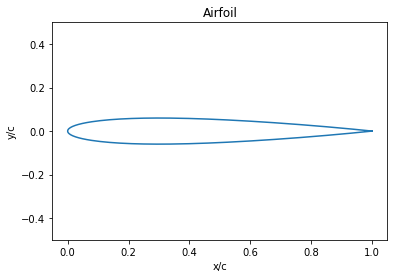

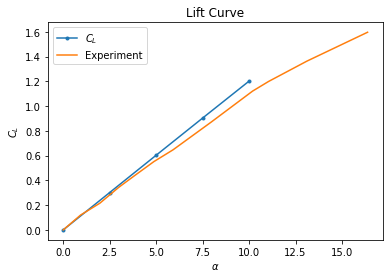

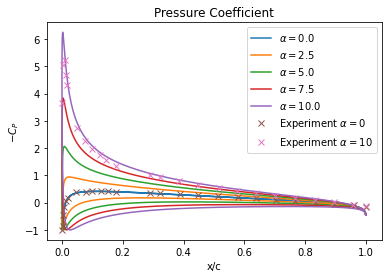

In [6]:
# Initialize the plots
figgeo, plotgeo = plt.subplots()
figcl, plotcl = plt.subplots()
figcp, plotcp = plt.subplots()

# Load the airfoil geometry points
[n, points, centroids] = load_points(plotgeo)

# Sweep over all desired angles
minalpha = 0
maxalpha = 10
alphastep = 2.5
sweep(minalpha, maxalpha, alphastep, n, points, centroids, plotcl, plotcp)

# Plot the experimental lift coefficient
data = np.loadtxt('experimental-cl.txt')
plotcl.plot(data[:, 0], data[:, 1], label='Experiment')
plotcl.legend()

# Plot the experiment pressure coefficients and save data
data = np.loadtxt('experimental-cp-0deg.txt')
plotcp.plot(data[:, 0], -data[:, 1], marker="x", linestyle='None', label='Experiment ' + r'$\alpha = 0$')
data = np.loadtxt('experimental-cp-10deg.txt')
plotcp.plot(data[:, 0], -data[:, 1], marker="x", linestyle='None', label='Experiment ' + r'$\alpha = 10$')
plotcp.legend()

# Save all the plots and save data
figgeo.savefig('plots/airfoil.pdf')
figcl.savefig('plots/cl.pdf')
figcp.savefig('plots/cp.pdf')

# Show all the plots
plt.show()